In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [3]:
def run_single_coin_backtest(
    csv_path: str,
    ticker: str,
    notional_usd: float = 200_000,
    sma_fast: int = 30,
    sma_slow: int = 70,
    entropy_window: int = 20,
    entropy_percentile: float = 0.8,
    atr_mult: float = 2,
    max_bars: int = 3,
    ofi_z_thresh: float = 0.5,
    vol_surge_percentile: float = 0.6,
    opening_range_bars: int = 4,
    mean_rev_zscore_thresh: float = 1.5,
    active_hours: set = None,
    use_fixed_sl: bool = True
):
    """
    Reads a 1-minute CSV from Binance, resamples to 15-minute bars, computes indicators,
    runs the strategy with a fixed notional, and returns:
      • coin_15m: DataFrame of 15-minute bars (with strategy_returns_pct, market_returns, etc.)
      • trade_log: DataFrame of all closed trades for this ticker
      • daily_returns_pct: Series of daily % returns of the strategy
      • market_daily_returns: Series of daily % returns for buy-&-hold
    """
    
    
    # 1) Load the CSV and set up a 1-minute DataFrame
    df_1m = pd.read_csv(csv_path)
    # 1) Load the CSV and set up a 1-minute DataFrame
    df_1m = pd.read_csv(csv_path)

# --- Auto-detect time column: prefer 'open_time' if available, else 'timestamp' ---
    time_col = None
    if 'open_time' in df_1m.columns:
        time_col = 'open_time'
    elif 'timestamp' in df_1m.columns:
        time_col = 'timestamp'
    else:
        raise ValueError(f"No suitable time column found in {csv_path}")

    df_1m['open_time'] = pd.to_datetime(df_1m[time_col])
    df_1m = df_1m.set_index('open_time')

    
    # --- FILTER OUT ALL DATA BEFORE 2020-01-01 ---
    df_1m = df_1m.loc["2020-01-01":]

    # 2) Resample to 15-minute bars
    coin_15m = df_1m.resample("15min").agg({
        "open":   "first",
        "high":   "max",
        "low":    "min",
        "close":  "last",
        "volume": "sum"
    }).dropna().reset_index()

    # 3) Prepare index and helper columns
    coin_15m["open_time"] = pd.to_datetime(coin_15m["open_time"])
    coin_15m = coin_15m.set_index("open_time").copy()
    coin_15m["hour"] = coin_15m.index.hour
    coin_15m["date"] = coin_15m.index.date

    # 4) Compute static indicators (ATR, vol_of_vol, OFI, momentum, vol_pct, NR4)
    def precompute_static_indicators(df):
        df = df.copy()
        df["tr"] = np.maximum(
            df["high"] - df["low"],
            np.maximum(
                (df["high"] - df["close"].shift(1)).abs(),
                (df["low"]  - df["close"].shift(1)).abs()
            )
        )
        df["atr"] = df["tr"].rolling(14).mean()

        df["vol_of_vol"] = df["atr"].rolling(20).std()
        df["vol_of_vol_thresh"] = df["vol_of_vol"].rolling(100).quantile(0.7)

        # Order Flow Imbalance (OFI)
        ofi_raw = (df["close"] - df["open"]) + (df["close"] - df["low"]) - (df["high"] - df["close"])
        df["ofi"] = pd.Series(ofi_raw).rolling(5).mean()
        df["ofi_z_mean"] = df["ofi"].rolling(10).mean()
        df["ofi_z_std"] = df["ofi"].rolling(10).std()
        df["ofi_z"] = (df["ofi"] - df["ofi_z_mean"]) / df["ofi_z_std"]

        # 3-period momentum
        df["momentum3"] = df["close"].pct_change(3)

        # Volume percentile (last bar’s rank in rolling 50)
        df["vol_pct"] = df["volume"].rolling(50).apply(
            lambda x: pd.Series(x).rank(pct=True).iloc[-1]
        )

        # NR4 (narrow range: current range = min of last 4 ranges)
        df["range"] = df["high"] - df["low"]
        # Use x[-1] because rolling(..., raw=True) passes a NumPy array
        df["is_NR4"] = df["range"].rolling(4).apply(lambda x: x[-1] == x.min(), raw=True)

        df = df.dropna()
        return df

    coin_15m = precompute_static_indicators(coin_15m)

    # 5) Compute rolling SMAs, VWAP, entropy, ORB, mean reversion
    coin_15m["sma_fast"] = coin_15m["close"].rolling(sma_fast).mean()
    coin_15m["sma_slow"] = coin_15m["close"].rolling(sma_slow).mean()
    coin_15m["sma_fast_slope"] = coin_15m["sma_fast"].diff(5)
    coin_15m["trend_up"]   = coin_15m["sma_fast_slope"] > 0
    coin_15m["trend_down"] = coin_15m["sma_fast_slope"] < 0

    coin_15m["vwap"] = (
        (coin_15m["close"] * coin_15m["volume"]).rolling(15).sum()
        / coin_15m["volume"].rolling(15).sum()
    )

    def calculate_entropy(arr, window, bins=10):
        ent = [np.nan] * len(arr)
        for idx in range(len(arr)):
            if idx < window:
                continue
            slice_ = arr[idx - window: idx]
            hist, _ = np.histogram(slice_, bins=bins, density=True)
            probs = hist / hist.sum()
            probs = probs[probs > 0]
            h = -np.sum(probs * np.log(probs))
            ent[idx] = h / np.log(bins)
        return np.array(ent)

    coin_15m["entropy_raw"] = calculate_entropy(coin_15m["close"].values, entropy_window, bins=10)
    coin_15m["entropy"] = pd.Series(coin_15m["entropy_raw"]).rolling(5).mean()
    coin_15m["entropy_thresh"] = coin_15m["entropy"].rolling(100).quantile(entropy_percentile)
    coin_15m["is_entropy_ok"] = coin_15m["entropy"] < coin_15m["entropy_thresh"]

    # Opening Range Breakout (ORB)
    def opening_range(group):
        high = group["high"].head(opening_range_bars).max()
        low  = group["low"].head(opening_range_bars).min()
        return pd.Series({"opening_range_high": high, "opening_range_low": low})

    if "opening_range_high" in coin_15m.columns or "opening_range_low" in coin_15m.columns:
        coin_15m = coin_15m.drop(columns=["opening_range_high", "opening_range_low"], errors="ignore")

    #orb_ranges = coin_15m.groupby("date", group_keys=False).apply(opening_range) 
    orb_ranges = coin_15m.groupby("date", group_keys=False).apply(opening_range, include_groups=False)

    coin_15m = coin_15m.merge(orb_ranges, left_on="date", right_index=True)

    coin_15m["orb_long"]  = coin_15m["close"] > coin_15m["opening_range_high"]
    coin_15m["orb_short"] = coin_15m["close"] < coin_15m["opening_range_low"]

    # Mean Reversion Z-Score
    coin_15m["sma_short"]    = coin_15m["close"].rolling(10).mean()
    coin_15m["price_std"]    = coin_15m["close"].rolling(10).std()
    coin_15m["price_zscore"] = (coin_15m["close"] - coin_15m["sma_short"]) / coin_15m["price_std"]

    coin_15m["mean_rev_long"]  = coin_15m["price_zscore"] < -mean_rev_zscore_thresh
    coin_15m["mean_rev_short"] = coin_15m["price_zscore"] >  mean_rev_zscore_thresh

    coin_15m["is_vol_of_vol_ok"] = coin_15m["vol_of_vol"] < coin_15m["vol_of_vol_thresh"]
    coin_15m["is_ofi_moderate"]  = coin_15m["ofi_z"].abs() > ofi_z_thresh
    coin_15m["is_momentum_up"]   = coin_15m["momentum3"] > 0
    coin_15m["is_momentum_down"] = coin_15m["momentum3"] < 0
    coin_15m["is_vol_surge"]     = coin_15m["vol_pct"] > vol_surge_percentile
    coin_15m["is_NR4"]           = coin_15m["is_NR4"].fillna(False)

    coin_15m = coin_15m.dropna().copy()

    if "open_time" not in coin_15m.columns:
        coin_15m = coin_15m.reset_index()
    coin_15m = coin_15m.set_index("open_time")

    # 6) Generate “signal” column
    coin_15m["signal"] = 0
    if active_hours is None:
        active_hours = set(range(24))

    mask_long = (
        coin_15m["hour"].isin(active_hours)
        & (
            (
                coin_15m["orb_long"]
                & coin_15m["is_entropy_ok"]
                & coin_15m["is_NR4"].shift(1).fillna(False)
                & coin_15m["is_vol_of_vol_ok"]
                & coin_15m["is_ofi_moderate"]
                & coin_15m["is_momentum_up"]
                & coin_15m["is_vol_surge"]
                & coin_15m["trend_up"]
                & (coin_15m["close"] > coin_15m["vwap"])
                & (coin_15m["sma_fast"] > coin_15m["sma_slow"])
            )
            |
            (
                coin_15m["mean_rev_long"]
                & coin_15m["is_entropy_ok"]
                & coin_15m["is_vol_of_vol_ok"]
                & coin_15m["is_ofi_moderate"]
                & (coin_15m["close"] < coin_15m["vwap"])
            )
        )
    )

    mask_short = (
        coin_15m["hour"].isin(active_hours)
        & (
            (
                coin_15m["orb_short"]
                & coin_15m["is_entropy_ok"]
                & coin_15m["is_NR4"].shift(1).fillna(False)
                & coin_15m["is_vol_of_vol_ok"]
                & coin_15m["is_ofi_moderate"]
                & coin_15m["is_momentum_down"]
                & coin_15m["is_vol_surge"]
                & coin_15m["trend_down"]
                & (coin_15m["close"] < coin_15m["vwap"])
                & (coin_15m["sma_fast"] < coin_15m["sma_slow"])
            )
            |
            (
                coin_15m["mean_rev_short"]
                & coin_15m["is_entropy_ok"]
                & coin_15m["is_vol_of_vol_ok"]
                & coin_15m["is_ofi_moderate"]
                & (coin_15m["close"] > coin_15m["vwap"])
            )
        )
    )

    coin_15m.loc[mask_long,  "signal"] =  1
    coin_15m.loc[mask_short, "signal"] = -1

    # 7) Backtest loop (bar-by-bar PnL & trade logging)
    position = 0
    entry_price = 0.0
    entry_time = None
    entry_index = None
    trail_stop = 0.0

    trade_pnls_usd = []
    returns_pct = []
    entries = []
    exits = []

    for i in range(1, len(coin_15m)):
        row      = coin_15m.iloc[i]
        prev_row = coin_15m.iloc[i - 1]
        signal   = row["signal"]
        price    = row["close"]
        atr      = row["atr"]

        if position == 0:
            if signal == 1:
                # Long entry
                position    = 1
                entry_price = price
                entry_time  = row.name
                entry_index = i
                qty         = notional_usd / entry_price
                trail_stop  = price - atr_mult * atr

            elif signal == -1:
                # Short entry
                position    = -1
                entry_price = price
                entry_time  = row.name
                entry_index = i
                qty         = notional_usd / entry_price
                trail_stop  = price + atr_mult * atr

            returns_pct.append(0.0)
            continue

        if position == 1:
            # Update trailing stop
            trail_stop = max(trail_stop, price - atr_mult * atr)

            if use_fixed_sl:
                stop_loss_price = entry_price * (1 - 0.03)
                sl_hit = price <= stop_loss_price
            else:
                sl_hit = False

            if (price < trail_stop) or sl_hit or ((i - entry_index) >= max_bars):
                exit_price = price
                pnl_usd = qty * (exit_price - entry_price)
                trade_pnls_usd.append(pnl_usd)

                entries.append((ticker, entry_time, entry_price, qty, "Long"))
                exits.append((exit_price, row.name, pnl_usd))

                position = 0
                returns_pct.append((exit_price - prev_row["close"]) / prev_row["close"])
                entry_price, entry_time, entry_index = 0.0, None, None
                continue

        elif position == -1:
            # Update trailing stop
            trail_stop = min(trail_stop, price + atr_mult * atr)

            if use_fixed_sl:
                stop_loss_price = entry_price * (1 + 0.02)
                sl_hit = price >= stop_loss_price
            else:
                sl_hit = False

            if (price > trail_stop) or sl_hit or ((i - entry_index) >= max_bars):
                exit_price = price
                pnl_usd = qty * (entry_price - exit_price)
                trade_pnls_usd.append(pnl_usd)

                entries.append((ticker, entry_time, entry_price, qty, "Short"))
                exits.append((exit_price, row.name, pnl_usd))

                position = 0
                returns_pct.append((prev_row["close"] - exit_price) / prev_row["close"])
                entry_price, entry_time, entry_index = 0.0, None, None
                continue

        prev_price = prev_row["close"]
        returns_pct.append(position * ((price - prev_price) / prev_price))

    coin_15m = coin_15m.iloc[1:].copy()
    coin_15m["strategy_returns_pct"] = returns_pct[: len(coin_15m)]
    coin_15m["market_returns"] = coin_15m["close"].pct_change().fillna(0)

    coin_15m["date"] = coin_15m.index.date
    daily_returns_pct = coin_15m.groupby("date")["strategy_returns_pct"].agg(lambda x: (1 + x).prod() - 1)
    market_daily_returns = coin_15m.groupby("date")["market_returns"].agg(lambda x: (1 + x).prod() - 1)
    trade_log = pd.DataFrame(entries, columns=["Ticker", "Entry Time", "Entry Price", "Qty (coin)", "Side"])
    if exits:
        exit_prices, exit_times, pnls_usd = zip(*exits)
        trade_log["Exit Price"] = exit_prices
        trade_log["Exit Time"]  = exit_times
        trade_log["PnL (USD)"]  = pnls_usd

        # Calculate return per trade (%)
        trade_log["Return (%)"] = trade_log["PnL (USD)"] / notional_usd * 100

    else:
        trade_log["Exit Price"] = np.nan
        trade_log["Exit Time"]  = pd.NaT
        trade_log["PnL (USD)"]  = np.nan
        trade_log["Return (%)"] = np.nan

    return coin_15m, trade_log, daily_returns_pct, market_daily_returns


# === MAIN SCRIPT ===

# 1) Define file paths for each ticker
paths = {
    "ETHUSDT": r"C:\Users\sandy\Desktop\SMU-MQF\QF621\Group Project\GP_13_06\ETHUSDT_1m_7 years from Binance.csv",
    "BTCUSDT": r"C:\Users\sandy\Desktop\SMU-MQF\QF621\Group Project\GP_13_06\BTCUSDT_1m_7 years from Binance.csv",
    "BNBUSDT": r"C:\Users\sandy\Desktop\SMU-MQF\QF621\Group Project\GP_13_06\BNBUSDT_1m_7 years from Binance.csv",
    #"SOLUSDT": r"D:\SMU\QF621 Quantitative Trading Strategies\projectdata\SOLUSDT_1m_5 years from Binance.csv",
    #"TRXUSDT": r"D:\SMU\QF621 Quantitative Trading Strategies\projectdata\TRXUSDT_1min_data.csv",
    "XRPUSDT": r"C:\Users\sandy\Desktop\SMU-MQF\QF621\Group Project\GP_13_06\XRPUSDT_1m_7 years from Binance.csv",
    "DOGEUSDT": r"C:\Users\sandy\Desktop\SMU-MQF\QF621\Group Project\GP_13_06\DOGEUSDT_1m_6 years from Binance.csv",
    "ADAUSDT": r"C:\Users\sandy\Desktop\SMU-MQF\QF621\Group Project\GP_13_06\ADAUSDT_1min_data.csv",
    "XLMUSDT": r"C:\Users\sandy\Desktop\SMU-MQF\QF621\Group Project\GP_13_06\XLMUSDT_1min_data.csv",
    #"SUIUSDT": r"D:\SMU\QF621 Quantitative Trading Strategies\projectdata\SUIUSDT_1min_data.csv",
    "LINKUSDT": r"C:\Users\sandy\Desktop\SMU-MQF\QF621\Group Project\GP_13_06\LINKUSDT_1min_data.csv",
    "AVAXUSDT": r"C:\Users\sandy\Desktop\SMU-MQF\QF621\Group Project\GP_13_06\AVAXUSDT_1min_data.csv",
    #"HBARUSDT": r"D:\SMU\QF621 Quantitative Trading Strategies\projectdata\HBARUSDT_1min_data.csv",
    "TONUSDT": r"C:\Users\sandy\Desktop\SMU-MQF\QF621\Group Project\GP_13_06\TONUSDT_1min_data.csv",
    #"SHIBUSDT": r"D:\SMU\QF621 Quantitative Trading Strategies\projectdata\SHIBUSDT_1min_data.csv"
}

all_coin_data = {}
all_trade_logs = []
all_daily_returns = {}
all_market_daily = {}

for ticker, csv_path in paths.items():
    print(f"\n==== Running backtest for {ticker} ====")
    coin_15m, trade_log, daily_ret, market_daily = run_single_coin_backtest(
        csv_path=csv_path,
        ticker=ticker,
        notional_usd=200_000,
        sma_fast=30,
        sma_slow=70,
        entropy_window=20,
        entropy_percentile=0.8,
        atr_mult=2,
        max_bars=3,
        ofi_z_thresh=0.5,
        vol_surge_percentile=0.6,
        opening_range_bars=4,
        mean_rev_zscore_thresh=1.5,
        active_hours= None,   # <---- Only run signals after 10:00 UTC
        use_fixed_sl=True
    )

    all_coin_data[ticker] = coin_15m
    all_trade_logs.append(trade_log)
    all_daily_returns[ticker] = daily_ret
    all_market_daily[ticker] = market_daily

# 2) Concatenate all trade logs
combined_trade_log = pd.concat(all_trade_logs, ignore_index=True)
combined_trade_log = combined_trade_log.sort_values("Entry Time").reset_index(drop=True)

print("\n=== Combined Trade Log (last 10 rows) ===")
print(combined_trade_log.tail(10))

# 3) Build portfolio daily USD PnL and % returns
# === Build realized daily USD PnL and % returns based on trade log ===

# 1. Get exit date for each trade (when the PnL is realized)
combined_trade_log["exit_date"] = pd.to_datetime(combined_trade_log["Exit Time"]).dt.date

# 2. Daily USD PnL per ticker (sum of all closed trades that day)
coin_daily_pnl_usd = (
    combined_trade_log.groupby(["Ticker", "exit_date"])["PnL (USD)"]
    .sum()
    .unstack(0)
    .fillna(0)
)

# 3. Portfolio USD PnL (sum across all tickers per day)
df_pnl_usd = coin_daily_pnl_usd.copy()
df_pnl_usd["Portfolio_USD_PnL"] = df_pnl_usd.sum(axis=1)



# 4. Calculate portfolio daily % return (relative to total capital)
total_capital = 200_000.0 * len(paths)
df_pnl_usd["Portfolio_Daily_Pct"] = df_pnl_usd["Portfolio_USD_PnL"] / total_capital
coin_daily_pct = {}
for ticker in paths.keys():
    # Each coin's daily return as % of its own notional capital (not total portfolio)
    coin_daily_pct[ticker] = df_pnl_usd[ticker] / 200_000.0

# 4) Compute portfolio performance metrics
port_daily_pct = df_pnl_usd["Portfolio_Daily_Pct"]
daily_avg = port_daily_pct.mean()
daily_vol = port_daily_pct.std(ddof=1)
daily_sharpe = daily_avg / daily_vol if daily_vol > 0 else np.nan
annual_sharpe = daily_sharpe * np.sqrt(365)

total_return_pct = (1 + port_daily_pct).prod() - 1
years = (pd.to_datetime(port_daily_pct.index[-1]) - pd.to_datetime(port_daily_pct.index[0])).days / 365.25
cagr_pct = ((1 + total_return_pct) ** (1 / years) - 1) if years > 0 else np.nan

cum_strat = (1 + port_daily_pct).cumprod()
peak_strat = cum_strat.cummax()
dd_strat = (cum_strat - peak_strat) / peak_strat
max_drawdown_pct = dd_strat.min() * 100

# 5) Buy & Hold comparison
all_coin_market_pnl_usd = {}
for ticker, market_daily in all_market_daily.items():
    all_coin_market_pnl_usd[ticker] = market_daily * 200_000.0

df_bh_usd = pd.DataFrame(all_coin_market_pnl_usd).fillna(0.0)
df_bh_usd["Portfolio_BH_PnL"] = df_bh_usd.sum(axis=1)
df_bh_usd["Portfolio_BH_Daily_Pct"] = df_bh_usd["Portfolio_BH_PnL"] / total_capital

bh_daily_pct = df_bh_usd["Portfolio_BH_Daily_Pct"]
bh_daily_avg = bh_daily_pct.mean()
bh_daily_vol = bh_daily_pct.std(ddof=1)
bh_daily_sharpe = bh_daily_avg / bh_daily_vol if bh_daily_vol > 0 else np.nan
bh_annual_sharpe = bh_daily_sharpe * np.sqrt(365)

bh_total_return_pct = (1 + bh_daily_pct).prod() - 1
bh_cagr_pct = ((1 + bh_total_return_pct) ** (1 / years) - 1) if years > 0 else np.nan


==== Running backtest for ETHUSDT ====

==== Running backtest for BTCUSDT ====

==== Running backtest for BNBUSDT ====

==== Running backtest for XRPUSDT ====

==== Running backtest for DOGEUSDT ====

==== Running backtest for ADAUSDT ====

==== Running backtest for XLMUSDT ====

==== Running backtest for LINKUSDT ====

==== Running backtest for AVAXUSDT ====

==== Running backtest for TONUSDT ====

=== Combined Trade Log (last 10 rows) ===
          Ticker          Entry Time  Entry Price     Qty (coin)   Side  \
107926   XLMUSDT 2025-06-06 23:00:00       0.2629  760745.530620   Long   
107927   ADAUSDT 2025-06-07 00:00:00       0.6514  307031.010132   Long   
107928  LINKUSDT 2025-06-07 00:30:00      13.6200   14684.287812  Short   
107929  AVAXUSDT 2025-06-07 00:45:00      19.8400   10080.645161  Short   
107930  AVAXUSDT 2025-06-07 02:45:00      19.8800   10060.362173  Short   
107931   XLMUSDT 2025-06-07 03:00:00       0.2641  757288.905718  Short   
107932  LINKUSDT 2025-06-07 0


=== PORTFOLIO PERFORMANCE REPORT ===
Period: 2020-01-03 to 2025-06-07  (5.43 years)
Total Return (Strategy):        662.57%
CAGR (Strategy):                45.41%
Max Drawdown (Strategy):        -14.51%
Annualized Sharpe (Strategy):   2.05
--- BUY & HOLD FOR COMPARISON ---
Total Return (Buy&Hold):        3850.62%
CAGR (Buy&Hold):                96.90%
Annualized Sharpe (Buy&Hold):   1.28


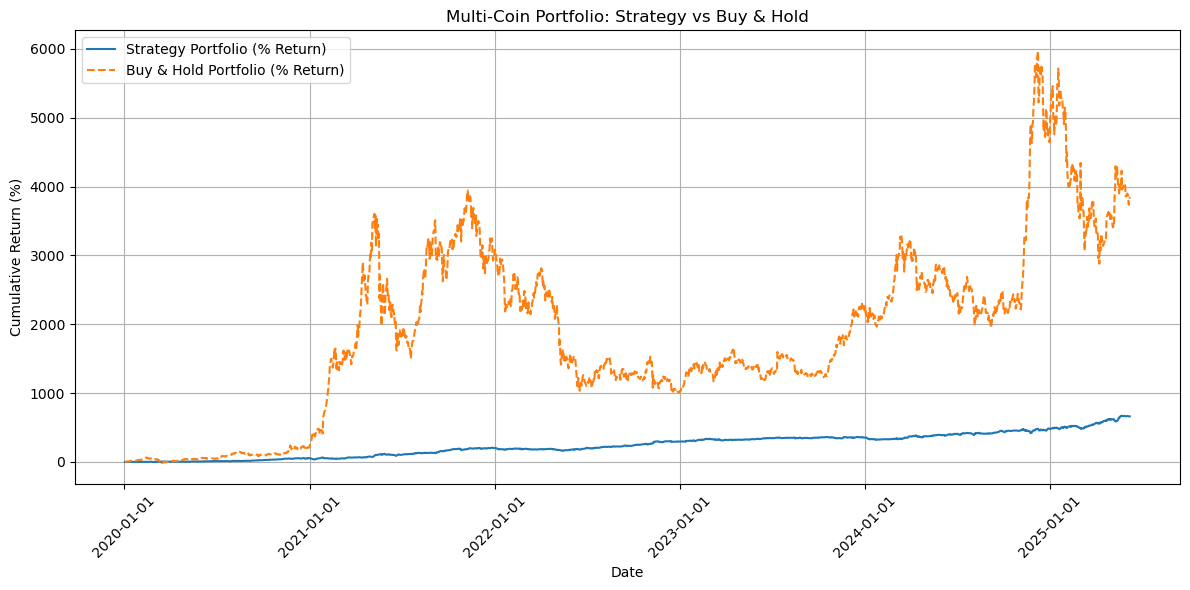


=== INDIVIDUAL COIN PERFORMANCE REPORT ===

=== Individual Coin Performance ===

          Total Return (%)  CAGR (%)  Max Drawdown (%)  Ann. Sharpe
Ticker                                                             
ETHUSDT             517.11     39.85            -46.09         1.05
BTCUSDT            1210.02     60.66            -20.76         1.74
BNBUSDT             175.01     20.49            -43.94         0.70
XRPUSDT             198.49     22.33            -65.09         0.67
DOGEUSDT           1252.60     61.61            -85.52         1.11
ADAUSDT             212.57     23.37            -60.17         0.69
XLMUSDT             213.46     23.43            -52.64         0.69
LINKUSDT            342.64     31.54            -66.48         0.80
AVAXUSDT            980.73     55.06            -45.56         1.10
TONUSDT              65.35      9.71            -24.47         0.72


In [5]:

# 6) Print portfolio summary
print("\n=== PORTFOLIO PERFORMANCE REPORT ===")
print(f"Period: {port_daily_pct.index[0]} to {port_daily_pct.index[-1]}  ({years:.2f} years)")
print(f"Total Return (Strategy):        {total_return_pct * 100:.2f}%")
print(f"CAGR (Strategy):                {cagr_pct * 100:.2f}%")
print(f"Max Drawdown (Strategy):        {max_drawdown_pct:.2f}%")
print(f"Annualized Sharpe (Strategy):   {annual_sharpe:.2f}")
print("--- BUY & HOLD FOR COMPARISON ---")
print(f"Total Return (Buy&Hold):        {bh_total_return_pct * 100:.2f}%")
print(f"CAGR (Buy&Hold):                {bh_cagr_pct * 100:.2f}%")
print(f"Annualized Sharpe (Buy&Hold):   {bh_annual_sharpe:.2f}")

# 7) (Optional) Plot Portfolio vs Buy & Hold
plt.figure(figsize=(12, 6))

cum_strat_pct = (1 + port_daily_pct).cumprod() - 1
plt.plot(
    cum_strat_pct.index,
    cum_strat_pct.values * 100,
    label="Strategy Portfolio (% Return)"
)

cum_bh_pct = (1 + bh_daily_pct).cumprod() - 1
plt.plot(
    cum_bh_pct.index,
    cum_bh_pct.values * 100,
    linestyle="--",
    label="Buy & Hold Portfolio (% Return)"
)

plt.title("Multi-Coin Portfolio: Strategy vs Buy & Hold")
plt.xlabel("Date")
plt.ylabel("Cumulative Return (%)")
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

    
print("\n=== INDIVIDUAL COIN PERFORMANCE REPORT ===")
summary = []

for ticker in paths.keys():
    pct = coin_daily_pct[ticker]
    # Cumulative return (%)
    total_return = (1 + pct).prod() - 1
    # Period length in years
    if len(pct) > 1:
        years_coin = (pd.to_datetime(pct.index[-1]) - pd.to_datetime(pct.index[0])).days / 365.25
    else:
        years_coin = np.nan
    # CAGR
    cagr_coin = ((1 + total_return) ** (1 / years_coin) - 1) if years_coin > 0 else np.nan
    # Sharpe (annualized)
    avg = pct.mean()
    vol = pct.std(ddof=1)
    sharpe = avg / vol if vol > 0 else np.nan
    annual_sharpe = sharpe * np.sqrt(365)
    # Max drawdown
    cum = (1 + pct).cumprod()
    peak = cum.cummax()
    dd = (cum - peak) / peak
    max_dd = dd.min() * 100

    summary.append({
        "Ticker": ticker,
        "Total Return (%)": total_return * 100,
        "CAGR (%)": cagr_coin * 100,
        "Max Drawdown (%)": max_dd,
        "Ann. Sharpe": annual_sharpe,
    })

# Make DataFrame
summary_df = pd.DataFrame(summary)
summary_df = summary_df.set_index("Ticker")
# Format display
print("\n=== Individual Coin Performance ===\n")
print(summary_df.round(2))

In [7]:
combined_trade_log.to_csv(r"C:\Users\sandy\Desktop\SMU-MQF\QF621\Group Project\GP_13_06\combined_trade_log_06.27.csv")

In [9]:
combined_trade_log.head(3)

,Ticker,Entry Time,Entry Price,Qty (coin),Side,Exit Price,Exit Time,PnL (USD),Return (%),exit_date
0,BTCUSDT,2020-01-03 16:00:00,7356.78000,2.718581e+01,Short,7386.03000,2020-01-03 16:45:00,-795.184850,-0.397592,2020-01-03
1,XLMUSDT,2020-01-03 16:00:00,0.04545,4.400440e+06,Short,0.04551,2020-01-03 16:45:00,-264.026403,-0.132013,2020-01-03
2,XRPUSDT,2020-01-03 16:15:00,0.19289,1.036860e+06,Short,0.19300,2020-01-03 17:00:00,-114.054643,-0.057027,2020-01-03


In [35]:
combined_trade_log.tail(3)

,Ticker,Entry Time,Entry Price,Qty (coin),Side,Exit Price,Exit Time,PnL (USD),Return (%),exit_date,PnL_pct,date,time_str,hour
107933,ADAUSDT,2025-06-07 03:00:00,0.6595,303260.045489,Short,0.662,2025-06-07 03:45:00,-758.150114,-0.379075,2025-06-07,-0.003791,2025-06-07,03:00,3
107934,TONUSDT,2025-06-07 05:00:00,3.1850,62794.348509,Short,3.183,2025-06-07 05:45:00,125.588697,0.062794,2025-06-07,0.000628,2025-06-07,05:00,5
107935,AVAXUSDT,2025-06-07 05:30:00,20.2700,9866.798224,Short,20.270,2025-06-07 06:15:00,0.000000,0.000000,2025-06-07,0.000000,2025-06-07,05:30,5


In [37]:
combined_trade_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107936 entries, 0 to 107935
Data columns (total 14 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Ticker       107936 non-null  object        
 1   Entry Time   107936 non-null  datetime64[ns]
 2   Entry Price  107936 non-null  float64       
 3   Qty (coin)   107936 non-null  float64       
 4   Side         107936 non-null  object        
 5   Exit Price   107936 non-null  float64       
 6   Exit Time    107936 non-null  datetime64[ns]
 7   PnL (USD)    107936 non-null  float64       
 8   Return (%)   107936 non-null  float64       
 9   exit_date    107936 non-null  object        
 10  PnL_pct      107936 non-null  float64       
 11  date         107936 non-null  object        
 12  time_str     107936 non-null  object        
 13  hour         107936 non-null  int32         
dtypes: datetime64[ns](2), float64(6), int32(1), object(5)
memory usage: 11.1+ MB


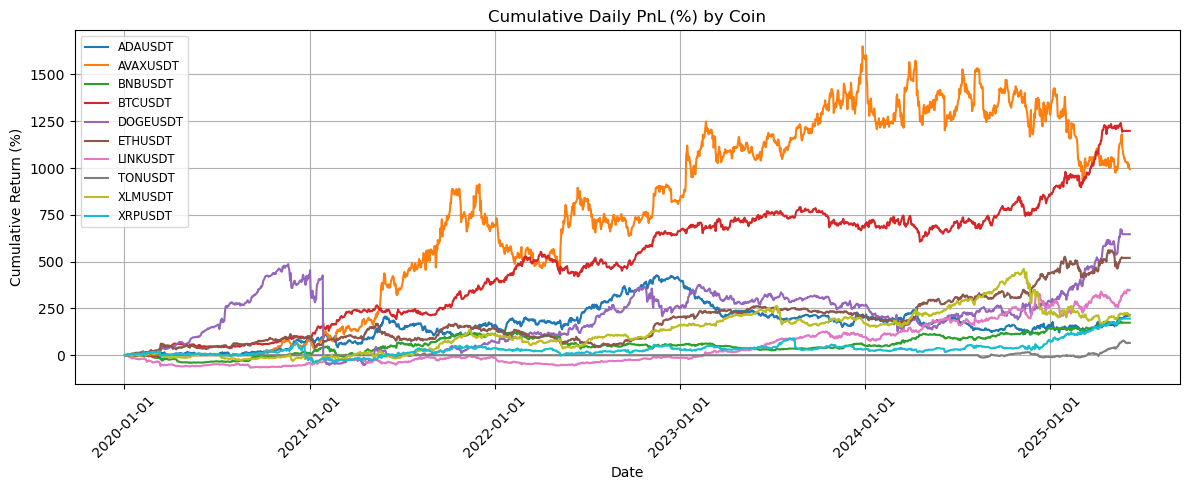

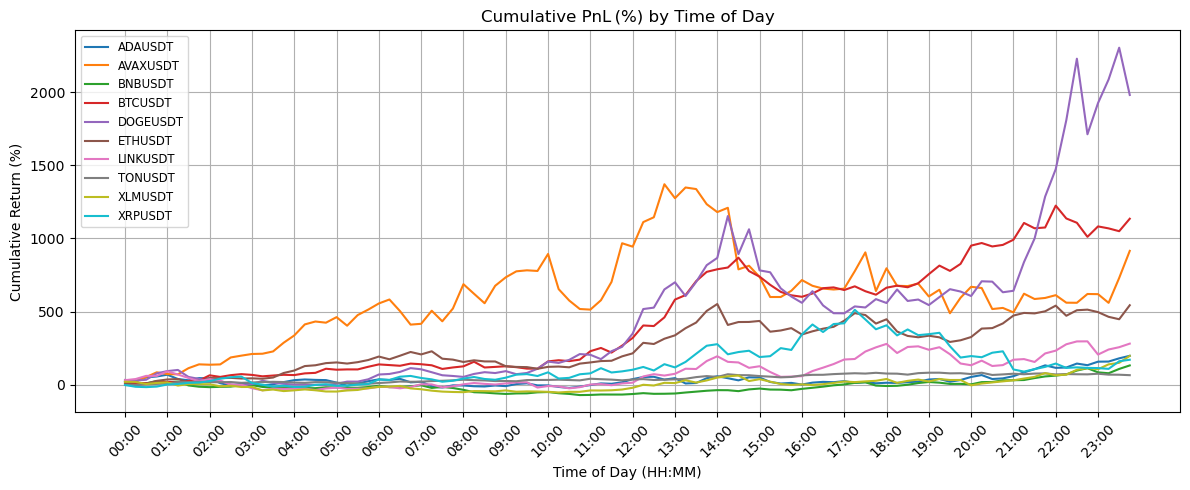

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# ----------------------------------------------------------------------
# ASSUME `combined_trade_log` is your DataFrame with at least these columns:
#   • 'Ticker'      (e.g. 'BTCUSDT', 'XRPUSDT', etc.)
#   • 'Entry Time'  (datetime or string that can be parsed as datetime)
#   • 'PnL (USD)'   (float)
#
# If your DataFrame has a different name, replace `combined_trade_log` below
# with the correct variable.
# ----------------------------------------------------------------------

# 1) Convert 'Entry Time' to datetime (if it isn't already)
combined_trade_log['Entry Time'] = pd.to_datetime(combined_trade_log['Entry Time'])

# 2) Compute percent‐PnL assuming a fixed notional of 200,000 USD per trade
fixed_notional = 200_000.0
combined_trade_log['PnL_pct'] = combined_trade_log['PnL (USD)'] / fixed_notional

# 3) Extract calendar date and HH:MM string for grouping
combined_trade_log['date']     = combined_trade_log['Entry Time'].dt.date
combined_trade_log['time_str'] = combined_trade_log['Entry Time'].dt.strftime('%H:%M')

# 4) Build a sorted list of all tickers (should be 5 distinct coins)
tickers = sorted(combined_trade_log['Ticker'].unique().tolist())



# ================================
# PART A: DATE‐BASED CUMULATIVE PnL
# ================================

# A.1) Sum PnL_pct by ['Ticker', 'date']
df_daily = (
    combined_trade_log
    .groupby(['Ticker', 'date'])['PnL_pct']
    .sum()
    .reset_index()       # columns: ['Ticker', 'date', 'PnL_pct']
)

# A.2) Pivot so each column is one coin, index = date
df_pivot = df_daily.pivot(index='date', columns='Ticker', values='PnL_pct').fillna(0.0)

# A.3) Compute cumulative return (%) for each coin:
df_cum = (1 + df_pivot).cumprod() - 1

# A.4) Plot all five coins on a single date‐based figure
plt.figure(figsize=(12, 5))
for coin in tickers:
    plt.plot(
        df_cum.index,
        df_cum[coin] * 100,
        label=coin,
        linewidth=1.5
    )

plt.title('Cumulative Daily PnL (%) by Coin')
plt.xlabel('Date')
plt.ylabel('Cumulative Return (%)')
plt.legend(loc='upper left', fontsize='small')
plt.grid(True)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




# ===================================
# PART B: TIME‐OF‐DAY‐BASED CUMULATIVE PnL
# ===================================

# B.1) Sum PnL_pct by ['Ticker', 'time_str']
df_time = (
    combined_trade_log
    .groupby(['Ticker', 'time_str'])['PnL_pct']
    .sum()
    .reset_index()       # columns: ['Ticker', 'time_str', 'PnL_pct']
)

# B.2) Pivot so each column is one coin, index = time_str (e.g., '00:00', '00:15', …)
df_time_pivot = df_time.pivot(index='time_str', columns='Ticker', values='PnL_pct').fillna(0.0)

# B.3) Sort the index so '00:00', '00:15', …, '23:45'
df_time_pivot = df_time_pivot.sort_index()

# B.4) Compute cumulative return (%) for each coin by time‐of‐day
df_time_cum = (1 + df_time_pivot).cumprod() - 1

# B.5) Plot all five coins on a single time‐of‐day‐based figure
plt.figure(figsize=(12, 5))
for coin in tickers:
    plt.plot(
        df_time_cum.index,
        df_time_cum[coin] * 100,
        label=coin,
        linewidth=1.5
    )

plt.title('Cumulative PnL (%) by Time of Day')
plt.xlabel('Time of Day (HH:MM)')
plt.ylabel('Cumulative Return (%)')
plt.legend(loc='upper left', fontsize='small')
plt.grid(True)
# Reduce clutter by rotating every 4th label
xticks = df_time_cum.index[::4]
plt.xticks(xticks, rotation=45)
plt.tight_layout()
plt.show()


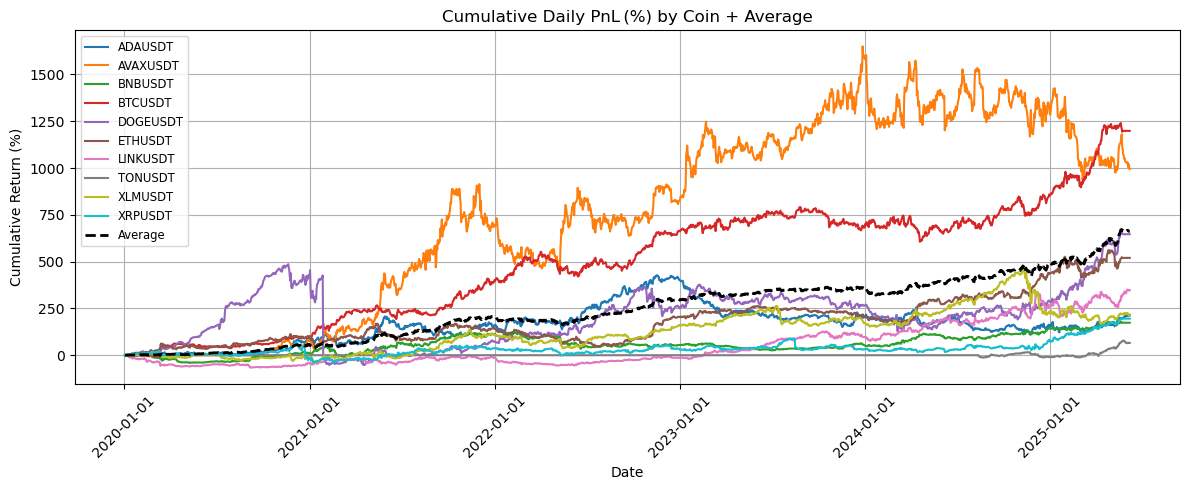

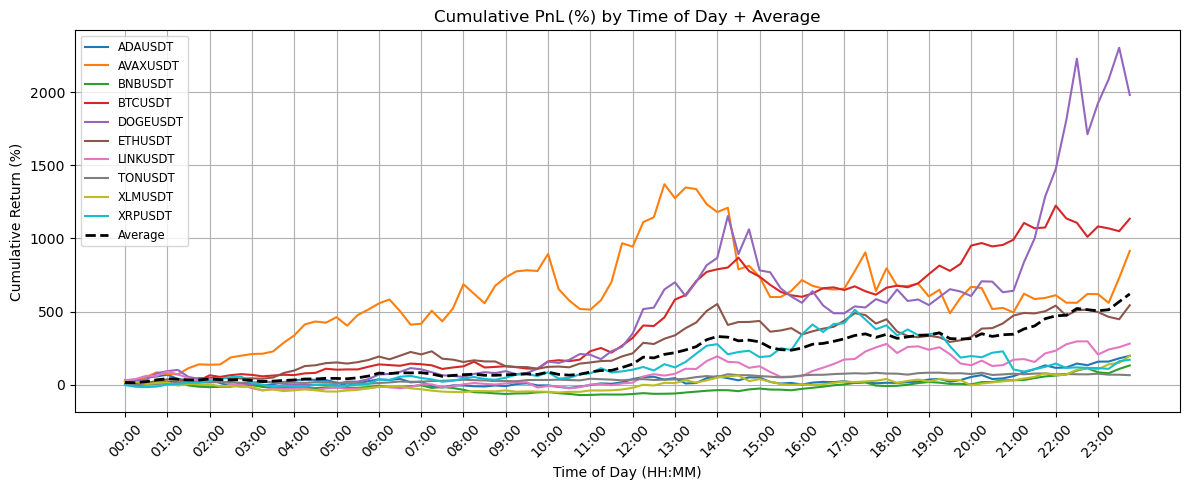

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# ----------------------------------------------------------------------
# ASSUME `combined_trade_log` is your DataFrame with at least these columns:
#   • 'Ticker'      (e.g. 'BTCUSDT', 'XRPUSDT', etc.)
#   • 'Entry Time'  (datetime or string that can be parsed as datetime)
#   • 'PnL (USD)'   (float)
#
# If your DataFrame has a different name, replace `combined_trade_log` below
# with the correct variable.
# ----------------------------------------------------------------------

# 1) Convert 'Entry Time' to datetime (if it isn't already)
combined_trade_log['Entry Time'] = pd.to_datetime(combined_trade_log['Entry Time'])

# 2) Compute percent‐PnL assuming a fixed notional of 200,000 USD per trade
fixed_notional = 200_000.0
combined_trade_log['PnL_pct'] = combined_trade_log['PnL (USD)'] / fixed_notional

# 3) Extract calendar date and HH:MM string for grouping
combined_trade_log['date']     = combined_trade_log['Entry Time'].dt.date
combined_trade_log['time_str'] = combined_trade_log['Entry Time'].dt.strftime('%H:%M')

# 4) Build a sorted list of all tickers (should be 5 distinct coins)
tickers = sorted(combined_trade_log['Ticker'].unique().tolist())



# ================================
# PART A: DATE‐BASED CUMULATIVE PNL + AVERAGE
# ================================

# A.1) Sum PnL_pct by ['Ticker', 'date']
df_daily = (
    combined_trade_log
    .groupby(['Ticker', 'date'])['PnL_pct']
    .sum()
    .reset_index()       # columns: ['Ticker', 'date', 'PnL_pct']
)

# A.2) Pivot so each column is one coin, index = date
df_pivot = df_daily.pivot(index='date', columns='Ticker', values='PnL_pct').fillna(0.0)

# A.3) Compute average daily %‐PnL across all coins
df_pivot['Avg_Daily_pct'] = df_pivot[tickers].mean(axis=1)

# A.4) Compute cumulative return (%) for each coin
df_cum = (1 + df_pivot[tickers]).cumprod() - 1

# A.5) Compute cumulative return (%) for the average series
df_avg_cum = (1 + df_pivot['Avg_Daily_pct']).cumprod() - 1

# A.6) Plot all five coins + average on a single date‐based figure
plt.figure(figsize=(12, 5))
for coin in tickers:
    plt.plot(
        df_cum.index,
        df_cum[coin] * 100,
        label=coin,
        linewidth=1.5
    )

# Plot the average cumulative line (thicker and dashed)
plt.plot(
    df_avg_cum.index,
    df_avg_cum * 100,
    label='Average',
    linestyle='--',
    color='black',
    linewidth=2
)

plt.title('Cumulative Daily PnL (%) by Coin + Average')
plt.xlabel('Date')
plt.ylabel('Cumulative Return (%)')
plt.legend(loc='upper left', fontsize='small')
plt.grid(True)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




# ===================================
# PART B: TIME‐OF‐DAY‐BASED CUMULATIVE PNL + AVERAGE
# ===================================

# B.1) Sum PnL_pct by ['Ticker', 'time_str']
df_time = (
    combined_trade_log
    .groupby(['Ticker', 'time_str'])['PnL_pct']
    .sum()
    .reset_index()       # columns: ['Ticker', 'time_str', 'PnL_pct']
)

# B.2) Pivot so each column is one coin, index = time_str (e.g., '00:00', '00:15', …)
df_time_pivot = df_time.pivot(index='time_str', columns='Ticker', values='PnL_pct').fillna(0.0)

# B.3) Compute average PnL% at each time‐bucket
df_time_pivot['Avg_Time_pct'] = df_time_pivot[tickers].mean(axis=1)

# B.4) Sort the index so '00:00', '00:15', …, '23:45'
df_time_pivot = df_time_pivot.sort_index()

# B.5) Compute cumulative return (%) for each coin by time‐of‐day
df_time_cum = (1 + df_time_pivot[tickers]).cumprod() - 1

# B.6) Compute cumulative return (%) for the average time series
df_avg_time_cum = (1 + df_time_pivot['Avg_Time_pct']).cumprod() - 1

# B.7) Plot all five coins + average on a single time‐of‐day‐based figure
plt.figure(figsize=(12, 5))
for coin in tickers:
    plt.plot(
        df_time_cum.index,
        df_time_cum[coin] * 100,
        label=coin,
        linewidth=1.5
    )

# Plot the average cumulative line (thicker and dashed)
plt.plot(
    df_avg_time_cum.index,
    df_avg_time_cum * 100,
    label='Average',
    linestyle='--',
    color='black',
    linewidth=2
)

plt.title('Cumulative PnL (%) by Time of Day + Average')
plt.xlabel('Time of Day (HH:MM)')
plt.ylabel('Cumulative Return (%)')
plt.legend(loc='upper left', fontsize='small')
plt.grid(True)
# Reduce clutter by rotating every 4th label
xticks = df_time_cum.index[::4]
plt.xticks(xticks, rotation=45)
plt.tight_layout()
plt.show()


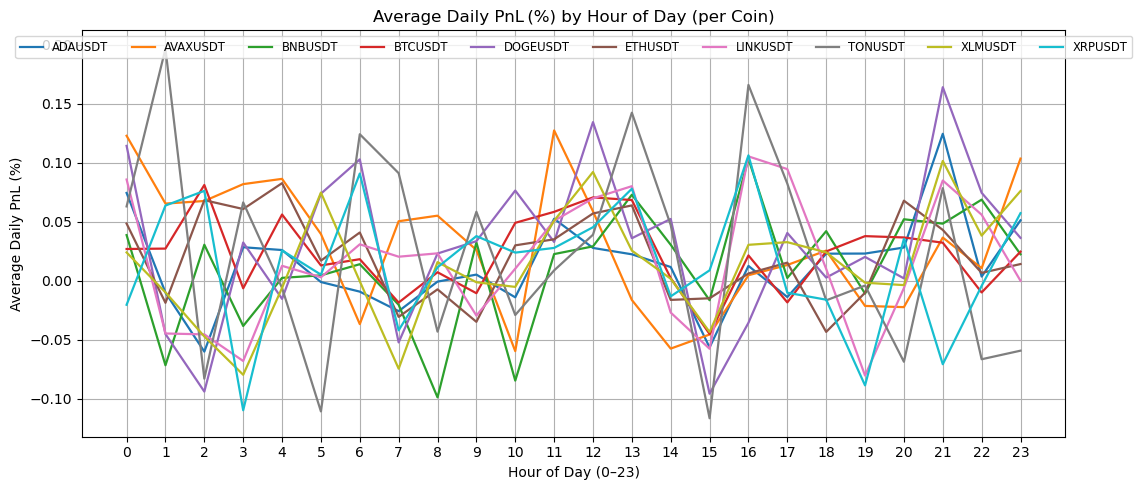

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------------------------------------------------
# ASSUME `combined_trade_log` is your DataFrame with at least these columns:
#   • 'Ticker'      (e.g. 'BTCUSDT', 'XRPUSDT', etc.)
#   • 'Entry Time'  (datetime or string that can be parsed as datetime)
#   • 'PnL (USD)'   (float)
#
# If your DataFrame has a different name, replace `combined_trade_log` below
# with the correct variable.
# ----------------------------------------------------------------------

# 1) Parse 'Entry Time' as datetime (if it isn’t already)
combined_trade_log['Entry Time'] = pd.to_datetime(combined_trade_log['Entry Time'])

# 2) Compute percent‐PnL assuming a fixed notional of $200,000 per trade
fixed_notional = 200_000.0
combined_trade_log['PnL_pct'] = combined_trade_log['PnL (USD)'] / fixed_notional

# 3) Extract calendar date and hour‐of‐day for grouping
combined_trade_log['date'] = combined_trade_log['Entry Time'].dt.date
combined_trade_log['hour'] = combined_trade_log['Entry Time'].dt.hour

# 4) Aggregate "daily PnL_pct per coin per hour"
#    This sums up all trades for each (Ticker, date, hour)
df_hourly_daily = (
    combined_trade_log
    .groupby(['Ticker', 'date', 'hour'])['PnL_pct']
    .sum()
    .reset_index()   # columns now: ['Ticker', 'date', 'hour', 'PnL_pct']
)

# 5) Compute "average daily PnL_pct at each hour" by averaging across dates
#    For each coin and each hour, take the mean of that day's PnL_pct
df_hourly_avg = (
    df_hourly_daily
    .groupby(['Ticker', 'hour'])['PnL_pct']
    .mean()
    .reset_index()   # columns: ['Ticker', 'hour', 'PnL_pct']
)

# 6) Pivot into a table: index = hour (0–23), columns = Ticker, values = average PnL_pct
df_hourly_pivot = df_hourly_avg.pivot(index='hour', columns='Ticker', values='PnL_pct').fillna(0.0)

# 7) (Optional) Convert to percentage for readability
df_hourly_pct = df_hourly_pivot * 100.0
# Now `df_hourly_pct.loc[h, coin]` is the average daily PnL (%) that coin achieved during hour = h.

# -------------------------------
# 8) Plotting “Average Daily PnL (%) by Hour of Day” for each coin
# -------------------------------
plt.figure(figsize=(12, 5))
for coin in df_hourly_pct.columns:
    plt.plot(
        df_hourly_pct.index,
        df_hourly_pct[coin],
        label=coin,
        linewidth=1.6
    )

plt.title('Average Daily PnL (%) by Hour of Day (per Coin)')
plt.xlabel('Hour of Day (0–23)')
plt.ylabel('Average Daily PnL (%)')
plt.xticks(range(0, 24))       # show all 24 hours on x‐axis
plt.grid(True)
plt.legend(loc='upper center', fontsize='small', ncol=len(df_hourly_pct.columns))
plt.tight_layout()
plt.show()


In [15]:
import pandas as pd

# Step 1: Parse datetime
combined_trade_log['Entry Time'] = pd.to_datetime(combined_trade_log['Entry Time'])

# Step 2: Compute percentage PnL (assuming fixed notional of $200,000 per trade)
fixed_notional = 200_000.0
combined_trade_log['PnL_pct'] = combined_trade_log['PnL (USD)'] / fixed_notional

# Step 3: Extract hour of day
combined_trade_log['hour'] = combined_trade_log['Entry Time'].dt.hour

# Step 4: Compute average PnL per trade (%) for each coin by hour
df_hourly_pct_trade = (
    combined_trade_log
    .groupby(['hour', 'Ticker'])['PnL_pct']
    .mean()
    .unstack(fill_value=0.0) * 100.0  # convert to percentage
)

# Result: df_hourly_pct_trade is a table:
# Rows = hours (0–23), Columns = coins (tickers), Values = average PnL per trade (%)


In [16]:
df_hourly_pct_trade.head(3)

Ticker,ADAUSDT,AVAXUSDT,BNBUSDT,BTCUSDT,DOGEUSDT,ETHUSDT,LINKUSDT,TONUSDT,XLMUSDT,XRPUSDT
hour,,,,,,,,,,
0,0.073241,0.120756,0.038124,0.026654,0.113623,0.047952,0.085307,0.063058,0.023714,-0.019865
1,-0.009917,0.064466,-0.071178,0.026993,-0.044452,-0.018482,-0.044044,0.196710,-0.009710,0.063116
2,-0.059776,0.067466,0.030494,0.080256,-0.093436,0.067833,-0.044980,-0.082976,-0.046879,0.075543


In [23]:
pip install gymnasium stable-baselines3 numpy pandas matplotlib

   ---------------------------------------- 0.0/965.4 kB ? eta -:--:--
   --------------------------------------- 965.4/965.4 kB 15.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [21]:
df_hourly_pct_trade.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24 entries, 0 to 23
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ADAUSDT   24 non-null     float64
 1   AVAXUSDT  24 non-null     float64
 2   BNBUSDT   24 non-null     float64
 3   BTCUSDT   24 non-null     float64
 4   DOGEUSDT  24 non-null     float64
 5   ETHUSDT   24 non-null     float64
 6   LINKUSDT  24 non-null     float64
 7   TONUSDT   24 non-null     float64
 8   XLMUSDT   24 non-null     float64
 9   XRPUSDT   24 non-null     float64
dtypes: float64(10)
memory usage: 2.0 KB


In [41]:
combined_trade_log.info

<bound method DataFrame.info of           Ticker          Entry Time  Entry Price    Qty (coin)   Side  \
0        BTCUSDT 2020-01-03 16:00:00   7356.78000  2.718581e+01  Short   
1        XLMUSDT 2020-01-03 16:00:00      0.04545  4.400440e+06  Short   
2        XRPUSDT 2020-01-03 16:15:00      0.19289  1.036860e+06  Short   
3        BNBUSDT 2020-01-03 17:30:00     13.68990  1.460931e+04   Long   
4        BNBUSDT 2020-01-03 19:00:00     13.57120  1.473709e+04   Long   
...          ...                 ...          ...           ...    ...   
107931   XLMUSDT 2025-06-07 03:00:00      0.26410  7.572889e+05  Short   
107932  LINKUSDT 2025-06-07 03:00:00     13.77000  1.452433e+04  Short   
107933   ADAUSDT 2025-06-07 03:00:00      0.65950  3.032600e+05  Short   
107934   TONUSDT 2025-06-07 05:00:00      3.18500  6.279435e+04  Short   
107935  AVAXUSDT 2025-06-07 05:30:00     20.27000  9.866798e+03  Short   

        Exit Price           Exit Time    PnL (USD)  Return (%)   exit_date  \


In [53]:
combined_trade_log.head(3)

0   -0.397592
1   -0.132013
2   -0.057027
Name: Return (%), dtype: float64

In [7]:
pip install stable-baselines3[extra]

   ---------------------------------------- 0.0/3.5 MB ? eta -:--:--
   ---------------------------------------- 3.5/3.5 MB 67.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/965.4 kB ? eta -:--:--
   --------------------------------------- 965.4/965.4 kB 46.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/216.1 MB ? eta -:--:--
   ---- ---------------------------------- 25.4/216.1 MB 124.0 MB/s eta 0:00:02
   ------- ------------------------------- 43.8/216.1 MB 103.1 MB/s eta 0:00:02
   ------------ -------------------------- 66.8/216.1 MB 103.9 MB/s eta 0:00:02
   ---------------- ---------------------- 89.1/216.1 MB 105.3 MB/s eta 0:00:02
   ------------------- ------------------ 110.4/216.1 MB 105.2 MB/s eta 0:00:02
   ----------------------- -------------- 136.1/216.1 MB 107.3 MB/s eta 0:00:01
   ---------------------------- --------- 161.0/216.1 MB 108.3 MB/s eta 0:00:01
   ------------------------------- ------ 179.8/216.1 MB 106.4 MB/s eta 

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: C:\Users\USER\anaconda3\python.exe -m pip install --upgrade pip


In [23]:
pip install gym

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: C:\Users\USER\anaconda3\python.exe -m pip install --upgrade pip


In [25]:
pip install "shimmy>=2.0"

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: C:\Users\USER\anaconda3\python.exe -m pip install --upgrade pip


In [17]:
test_metrics

{'total_return': 0.13180708954844977,
 'annual_return': 0.7539346022781234,
 'volatility': 0.14104794507285814,
 'sharpe': 5.3452363441996935,
 'max_drawdown': 0.03624454010052768,
 'turnover': 0.74208766}

Testing: 100%|████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 566.16it/s]


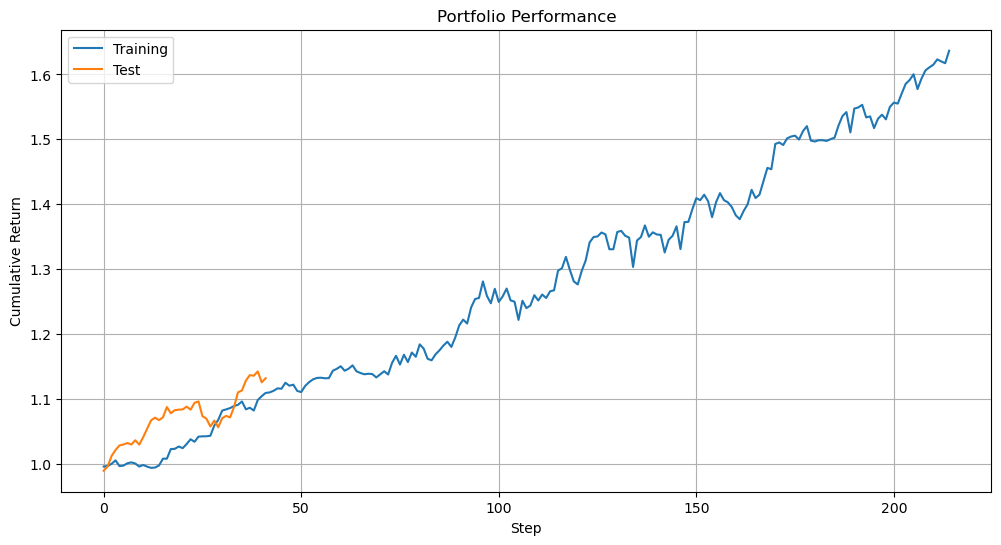

Training Metrics:
   total_return: 0.6365
  annual_return: 0.5901
     volatility: 0.1558
         sharpe: 3.7880
   max_drawdown: 0.0463
       turnover: 0.7421

Test Metrics:
   total_return: 0.1318
  annual_return: 0.7539
     volatility: 0.1410
         sharpe: 5.3452
   max_drawdown: 0.0362
       turnover: 0.7421


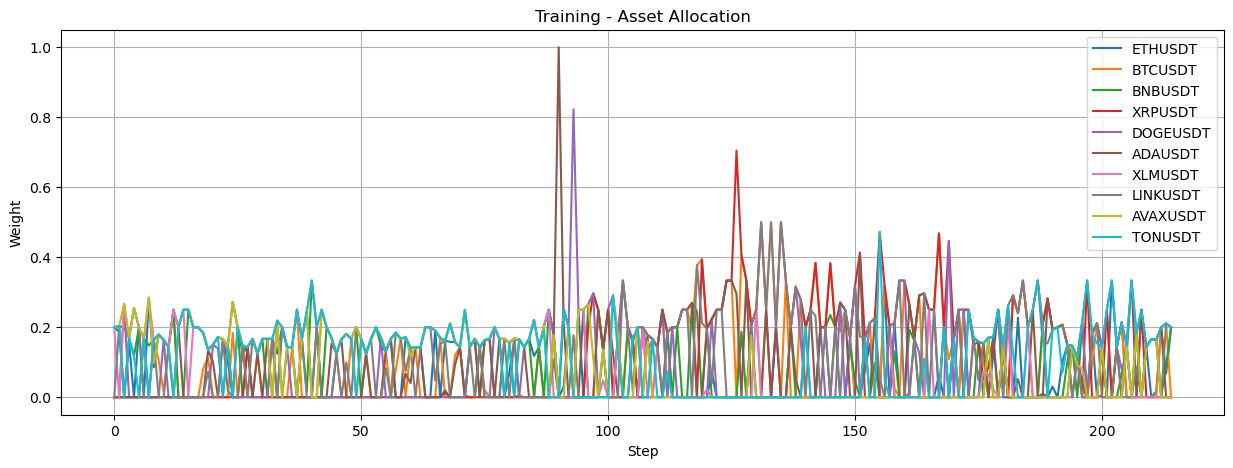

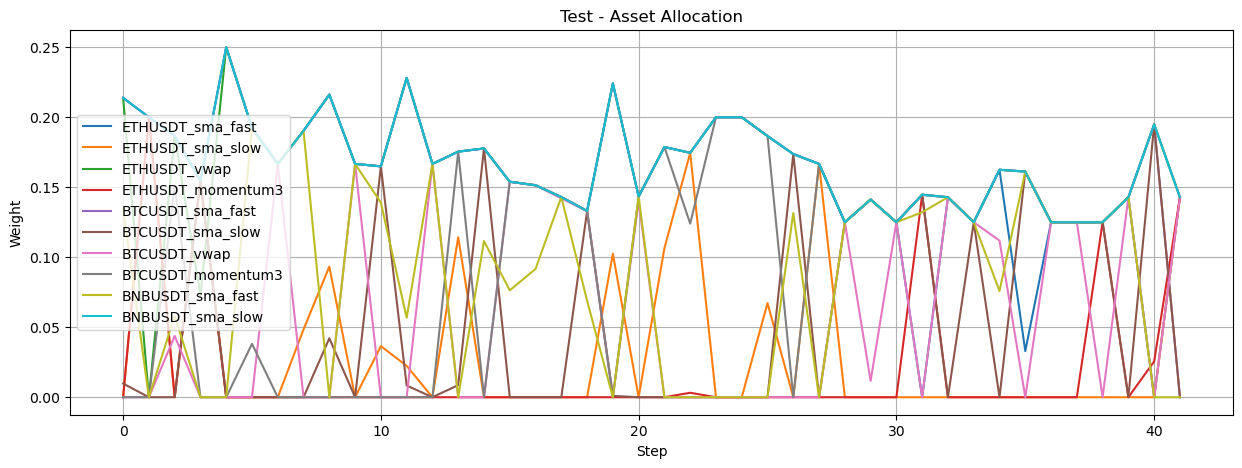

In [11]:
# Initialize tracker
perf_tracker = PerformanceTracker()

# ===== TRAINING PHASE =====
# Initialize with equal weights
current_weights = np.ones(train_returns.shape[1]) / train_returns.shape[1]

for i in tqdm(range(len(train_features) - lookback), desc="Training"):
    # Get current observation
    obs = train_features.iloc[i:i+lookback].values.flatten()
    
    # Get action from model
    action, _ = model.predict(obs, deterministic=False)
    
    # Normalize weights
    new_weights = np.clip(action, 0, 1)
    new_weights = new_weights / np.sum(new_weights)
    
    # Get returns for next period
    returns = train_returns.iloc[i+lookback].values
    
    # Record training step
    perf_tracker.record_train_step(returns, current_weights, new_weights, i)
    
    # Update weights
    current_weights = new_weights

# Finalize training metrics
train_metrics = perf_tracker.finalize_train_metrics()

# ===== TESTING PHASE ===== 
# Re-initialize with equal weights
current_weights = np.ones(holdout_returns.shape[1]) / holdout_returns.shape[1]

for i in tqdm(range(len(holdout_features) - lookback), desc="Testing"):
    # Get current observation
    obs = holdout_features.iloc[i:i+lookback].values.flatten()
    
    # Get action from model
    action, _ = model.predict(obs, deterministic=True)
    
    # Normalize weights
    new_weights = np.clip(action, 0, 1)
    new_weights = new_weights / np.sum(new_weights)
    
    # Get returns for next period
    returns = holdout_returns.iloc[i+lookback].values
    
    # Record test step
    perf_tracker.record_test_step(returns, new_weights, i)
    
    # Update weights (for consistency, though not used in test recording)
    current_weights = new_weights

# Finalize test metrics
test_metrics = perf_tracker.finalize_test_metrics()

# ===== VISUALIZATION =====
perf_tracker.plot_performance()
metrics_comparison = perf_tracker.print_metrics_comparison()

# Asset allocation analysis
def analyze_weights(history, asset_names, title):
    weights = np.array([x['weights'] for x in history])
    plt.figure(figsize=(15, 5))
    for i in range(weights.shape[1]):
        plt.plot(weights[:, i], label=asset_names[i])
    plt.title(f'{title} - Asset Allocation')
    plt.xlabel('Step')
    plt.ylabel('Weight')
    plt.legend()
    plt.grid(True)
    plt.show()

analyze_weights(perf_tracker.train_history, train_returns.columns, 'Training')
analyze_weights(perf_tracker.test_history, holdout_features.columns, 'Test')

In [139]:
# import warnings